# Tripartite with excitatory STDP

On the excitatory synapses

In [1]:
from brian2 import *
%matplotlib inline

INFO       Cache size for target 'cython': 2785973906 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the 'C:\Users\admin\.cython\brian_extensions' directory. [brian2]


In [2]:
# Constants
tau = 4*ms
I = 1.1/ms
gamma = 1/ms

# Non-dimensionalized constants
tp = tau/ms
curr = I*ms
g = gamma*ms
out = curr/g  #should be > the threshold of firing

# equation (1)
eqs = '''
dv/dt = I - gamma*v : 1
'''

# equation (2) 
eqs2 = '''
dv/dt = ((I/gamma) - v)/tau : 1
'''

In [3]:
start_scope()

n = 90

seed(21)

G1 = NeuronGroup(n, eqs2, threshold='v>1', reset='v = 0', method='exact')
G2 = NeuronGroup(n/3, eqs2, threshold='v>1', reset='v = 0', method='exact')

group1init = randint(0, 9, size=n)/10
group2init = randint(0, 9, size=n//3)/10

G1.v = group1init
G2.v = group2init

In [4]:
matrix = zeros((n, n))

def matcon(i,j):
        matrix[i, j] = 1

# each group of 30 to everything else
for i in range(30):
        for j in range(30, 90):
                matcon(i,j)
for i in range(30,60):
        for j in range(60, 90):
                matcon(i,j)
        for j in range(0, 30):
                matcon(i,j)
for i in range(60,90):
        for j in range(0, 60):
                matcon(i,j)

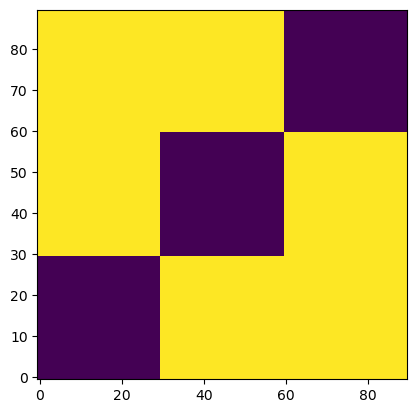

In [5]:
imshow(matrix, origin='lower');

In [6]:
inh = 0.02
exc = 0.01

p = 0.8
exc_matrix = choice(2, (30, 90), p=[1-p, p])

si, ti = matrix.nonzero()
se, te = exc_matrix.nonzero()

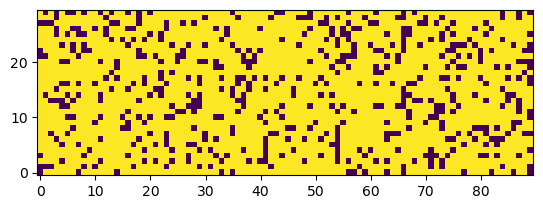

In [7]:
imshow(exc_matrix, origin='lower');

In [8]:
tau_stdp = 20*ms
# gmax = .01
# dApre = .01
# dApost = -dApre * taupre / taupost * 1.05
# dApost *= gmax
# dApre *= gmax

gmax = 1.0


I1 = Synapses(G1, G1, on_pre='v = out * (1-exp(-(tp * log(1/(1 - g*(v_post - inh)/curr)))/tp))')

# Excitatory synapses
E1 = Synapses(G2, G1,
              '''w : 1
              dApre/dt = -Apre/tau_stdp : 1 (event-driven)
              dApost/dt = -Apost/tau_stdp : 1 (event-driven)
              ''',
              on_pre='''Apre += 0.4
              w = clip(w + Apost, 0, gmax)
              v = out * (1-exp(-(tp * log(1/(1 - g*(v_post + exc*w)/curr)))/tp))''',
              on_post='''Apost -= 0.4
              w = clip(w + Apre, 0, gmax)
              ''')

I1.connect(i=si, j=ti)

E1.connect(i=se, j=te)

M1 = StateMonitor(G1, 'v', record=True)
Sp1 = SpikeMonitor(G1)

In [9]:
run(500*ms)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 8 lines of abstract code, first line is: '_Apost := Apost * exp(_lio_1 * (- (t - lastupdate))) (constant)'
 [brian2.codegen.generators.base]


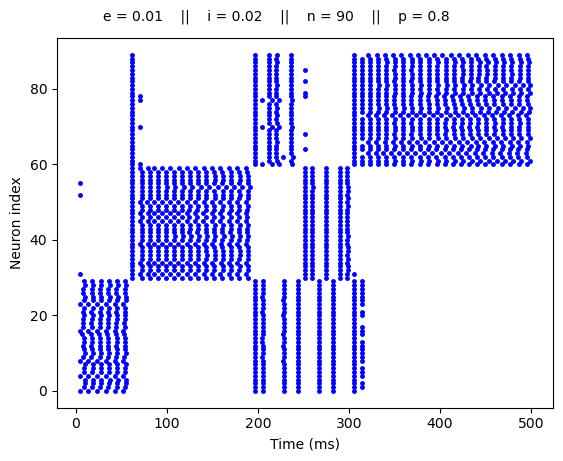

In [10]:
plot(Sp1.t/ms, Sp1.i, '.b', markersize=5)
xlabel('Time (ms)')
ylabel('Neuron index')
text(30, n+8, 'e = {}    ||    i = {}    ||    n = {}    ||    p = {}'.format(exc, inh, n, p))
show()

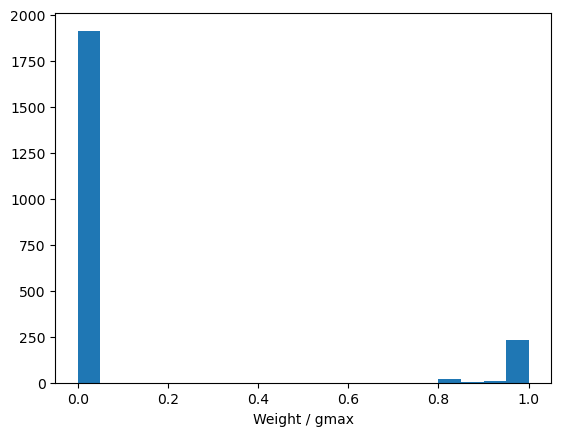

In [11]:
hist(E1.w / gmax, 20)
xlabel('Weight / gmax');